<a href="https://colab.research.google.com/github/saimasharleen/Active-Learning-Strategies-Across-Diverse-Machine-Learning-Models/blob/main/MNIST_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-gxc6z146
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-gxc6z146
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 3.5 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=3be9190e95e40a0ef0d4f70be2f5b04de1c2a095b583f8ca39d3889e7b8214a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-svmx0e1g/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [2]:
import numpy as np
import joblib
import collections
from sklearn.naive_bayes import MultinomialNB
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [3]:
# Load MNIST data
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
x, y = next(iter(dataloader))


100%|██████████| 9912422/9912422 [00:00<00:00, 86419820.08it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4605569.68it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32435015.91it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14432218.76it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Preprocessing
x = x.detach().cpu().numpy().reshape(x.size(0), -1)  # Flatten the images
x = x * 255  # Scale pixel values for Naive Bayes (MultinomialNB)
y = y.detach().cpu().numpy()

In [5]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0, stratify=y)

In [6]:
# Define confusion matrix print function
def CF_Print(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    CF = confusion_matrix(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print('Confusion Matrix:')
    print(CF)
    print('Accuracy: ', accuracy)
    print('Macro F1-score: ', macro_f1)
    print('Micro F1-score: ', micro_f1)
    print('Weighted F1-score: ', weighted_f1)
    print("---------------------------------")

In [7]:
# Active Learning with Naive Bayes
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    # Initialize the learner
    learner = ActiveLearner(
        estimator=MultinomialNB(),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    print("Number of initial data: ", n_initial)
    y_pred = learner.predict(x_test)
    CF_Print(y_test, y_pred)

    # Active Learning Loop
    for idx in range(n_queries):
        print('--- Query no: ', idx+1, ' ----')
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
        print('Instance', y_pool[query_idx])
        y_pred = learner.predict(x_test)
        CF_Print(y_test, y_pred)

        # Update the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)


In [8]:
AL_Retrain(30, 10, 20)

Number of initial data:  30
Confusion Matrix:
[[659   0  14   2   1   1   5   0 304   1]
 [  0 867  13   0  13   0   2   2 226   1]
 [  3   8 721  19  11   0   3   1 192  35]
 [  3  20  24 679  64   3   0   0 229   0]
 [  1   3  47   4 676   0   2   4 178  59]
 [ 14   2  24 192  65  52  21   0 525   8]
 [ 27  25 252   2   7   9 526   0 135   3]
 [ 24  19  38   4 296   0   0 584  42  37]
 [  1  11  39  32  65   2   3   2 815   5]
 [  6   6  32   6 653   0   0  31 121 137]]
Accuracy:  0.5716
Macro F1-score:  0.5559833452519947
Micro F1-score:  0.5716
Weighted F1-score:  0.5649506826254923
---------------------------------
--- Query no:  1  ----
Instance [1 3 4 1 5 3 4 8 5 2 4 8 9 8 2 5 8 9 9 9]
Confusion Matrix:
[[634   0  33   1   2  57   2   0 258   0]
 [  0 939  22   6   9   6   1   2 139   0]
 [  2   3 841   8  15   6   0   0 105  13]
 [  0  17  43 667  16  19   0   0 254   6]
 [  0   2  20   1 522   2   1   1 278 147]
 [  4   7  19 217  34  52   5   1 557   7]
 [ 13  27 305   1  24 

In [9]:
AL_Retrain(30, 10, 30)

Number of initial data:  30
Confusion Matrix:
[[659   0  14   2   1   1   5   0 304   1]
 [  0 867  13   0  13   0   2   2 226   1]
 [  3   8 721  19  11   0   3   1 192  35]
 [  3  20  24 679  64   3   0   0 229   0]
 [  1   3  47   4 676   0   2   4 178  59]
 [ 14   2  24 192  65  52  21   0 525   8]
 [ 27  25 252   2   7   9 526   0 135   3]
 [ 24  19  38   4 296   0   0 584  42  37]
 [  1  11  39  32  65   2   3   2 815   5]
 [  6   6  32   6 653   0   0  31 121 137]]
Accuracy:  0.5716
Macro F1-score:  0.5559833452519947
Micro F1-score:  0.5716
Weighted F1-score:  0.5649506826254923
---------------------------------
--- Query no:  1  ----
Instance [3 2 9 1 5 3 4 8 9 8 4 8 9 8 2 5 1 5 4 9 3 7 5 4 7 3 6 9 8 5]
Confusion Matrix:
[[609   0  18  21   5  51   4   0 277   2]
 [  0 928  13   4   6  10   0   1 162   0]
 [  1   2 759  18  34  25   6   0 127  21]
 [  0  13  23 579   9 137   1   0 250  10]
 [  0   2   9   2 470  61   6   3 194 227]
 [  2   7   6 148  36 219   2   2 476   5]
 [

In [10]:
AL_Retrain(50, 10, 20)

Number of initial data:  50
Confusion Matrix:
[[857   1  73   5   0   0   2   0  49   0]
 [  0 986  15   8   1   0   3   1 108   2]
 [  3   9 809  88   8   0  12   2  53   9]
 [ 12  17  84 845   5   1   0   0  56   2]
 [  1   2  90   5 606   0  14   3 143 110]
 [ 39   6  67 228  17  22  19   2 497   6]
 [ 19  18 304   6   1   2 612   0  24   0]
 [ 32  20  18  47 165   0   0 583  48 131]
 [  2  34  36 122   7   4   6   1 761   2]
 [ 11  10  36   8 363   0   0  26 152 386]]
Accuracy:  0.6467
Macro F1-score:  0.6163427138501851
Micro F1-score:  0.6467
Weighted F1-score:  0.6257197438860492
---------------------------------
--- Query no:  1  ----
Instance [4 8 5 9 1 1 1 8 5 3 5 3 4 4 9 8 8 2 7 7]
Confusion Matrix:
[[ 787    0   42    0    2   15    2    0  139    0]
 [   0 1032    9    5    1    2    2    1   70    2]
 [   3   32  759   58    9   12   14    3   94    9]
 [  13   31   78  778    4   52    0    2   62    2]
 [   0    5   57    2  601   22    9    2  159  117]
 [  25   17   3

In [11]:
AL_Retrain(50, 10, 30)

Number of initial data:  50
Confusion Matrix:
[[857   1  73   5   0   0   2   0  49   0]
 [  0 986  15   8   1   0   3   1 108   2]
 [  3   9 809  88   8   0  12   2  53   9]
 [ 12  17  84 845   5   1   0   0  56   2]
 [  1   2  90   5 606   0  14   3 143 110]
 [ 39   6  67 228  17  22  19   2 497   6]
 [ 19  18 304   6   1   2 612   0  24   0]
 [ 32  20  18  47 165   0   0 583  48 131]
 [  2  34  36 122   7   4   6   1 761   2]
 [ 11  10  36   8 363   0   0  26 152 386]]
Accuracy:  0.6467
Macro F1-score:  0.6163427138501851
Micro F1-score:  0.6467
Weighted F1-score:  0.6257197438860492
---------------------------------
--- Query no:  1  ----
Instance [4 8 5 9 1 1 1 8 5 3 5 3 4 4 9 8 8 2 7 7 7 1 0 2 6 5 8 6 9 4]
Confusion Matrix:
[[ 852    0   30    2    2    8    1    0   92    0]
 [   0 1010   22    2    1    2    3    2   80    2]
 [   4   52  776   42    9   13   11    3   77    6]
 [  18   61   80  740    4   50    0    4   58    7]
 [   3    7   65    2  605   28   10    5  146  

In [12]:
AL_Retrain(100, 10, 20)

Number of initial data:  100
Confusion Matrix:
[[ 836    1   27   68    1   16    3    0   35    0]
 [   0 1024   17    8    0   14    3    2   53    3]
 [   5    9  815  100    7   11    9    0   32    5]
 [   8   24   52  816   10   31    0    3   67   11]
 [   3    3   45    3  556    1   19    3  122  219]
 [  33   10   26  186   25  350   15    3  248    7]
 [  28   13  221    8    7   14  683    0   11    1]
 [  12   14   14   21   76    2    0  605   42  258]
 [   2   73   33  172   24   36    5    2  621    7]
 [   5    8   11   17  127    1    0   31  186  606]]
Accuracy:  0.6912
Macro F1-score:  0.6882242837915674
Micro F1-score:  0.6912
Weighted F1-score:  0.6928485413687187
---------------------------------
--- Query no:  1  ----
Instance [5 9 5 2 9 8 9 9 1 8 5 9 1 9 7 5 5 2 7 5]
Confusion Matrix:
[[ 797    0   14   50    1   88    2    0   35    0]
 [   0 1021   14    2    0   12    2    2   70    1]
 [   4   11  808   60    7   30    8    1   55    9]
 [   7   27   46  76

In [13]:
AL_Retrain(300, 10, 20)

Number of initial data:  300
Confusion Matrix:
[[ 858    1   17   13    5   36    8    0   49    0]
 [   0 1022   34    6    0    5    4    1   50    2]
 [   5    2  825   51   17    3   16    3   68    3]
 [   3   10   51  828   23   21    1    4   51   30]
 [   2    3   31    0  618   17   23    0   88  192]
 [  36   10   30  147   43  519   15    2   82   19]
 [  14   16  107    2    7   21  815    0    4    0]
 [   6    9    4   10   38    3    1  785   69  119]
 [   7   36   29   54   44   36    2    2  748   17]
 [   3    6    4   11  159    3    0   27   47  732]]
Accuracy:  0.775
Macro F1-score:  0.7735913019876011
Micro F1-score:  0.775
Weighted F1-score:  0.7770595064171062
---------------------------------
--- Query no:  1  ----
Instance [3 0 7 8 4 7 9 9 7 4 1 4 4 8 0 7 6 5 3 1]
Confusion Matrix:
[[ 873    1   15    8    5   22   12    0   51    0]
 [   0 1022   36    9    0    5    4    1   45    2]
 [   5    2  822   49   16    3   19    3   71    3]
 [   6   14   52  835 

In [14]:

AL_Retrain(300, 10, 30)

Number of initial data:  300
Confusion Matrix:
[[ 858    1   17   13    5   36    8    0   49    0]
 [   0 1022   34    6    0    5    4    1   50    2]
 [   5    2  825   51   17    3   16    3   68    3]
 [   3   10   51  828   23   21    1    4   51   30]
 [   2    3   31    0  618   17   23    0   88  192]
 [  36   10   30  147   43  519   15    2   82   19]
 [  14   16  107    2    7   21  815    0    4    0]
 [   6    9    4   10   38    3    1  785   69  119]
 [   7   36   29   54   44   36    2    2  748   17]
 [   3    6    4   11  159    3    0   27   47  732]]
Accuracy:  0.775
Macro F1-score:  0.7735913019876011
Micro F1-score:  0.775
Weighted F1-score:  0.7770595064171062
---------------------------------
--- Query no:  1  ----
Instance [5 1 5 8 4 7 9 3 7 4 5 4 1 8 0 7 6 3 4 9 7 0 8 3 5 1 5 9 7 9]
Confusion Matrix:
[[ 873    1   15    8    5   21   12    0   52    0]
 [   0 1025   36    7    1    4    4    1   44    2]
 [   6    5  824   44   16    4   19    3   69    3]
 [

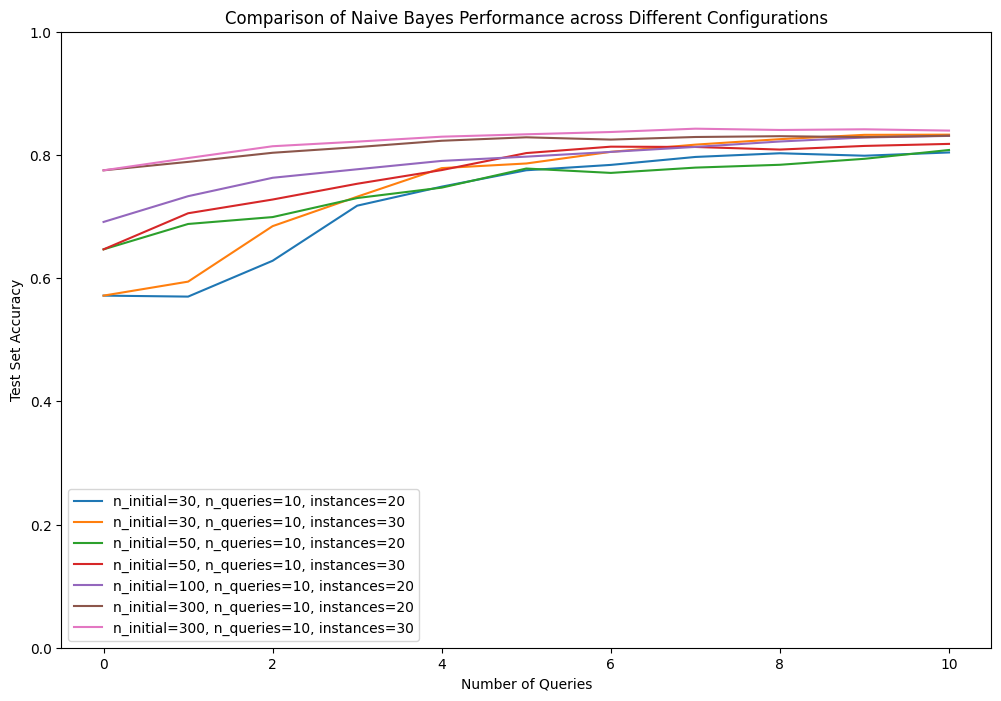

In [15]:
#plot_for_performance

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.naive_bayes import MultinomialNB

# Define the active learning function with parameters for Naive Bayes
def AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    learner = ActiveLearner(
        estimator=MultinomialNB(),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])

        # Remove the queried instance from the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Calculate and record performance
        model_accuracy = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(model_accuracy)

    return performance_history

# Configurations to compare
configurations = [
    (30, 10, 20),
    (30, 10, 30),
    (50, 10, 20),
    (50, 10, 30),
    (100, 10, 20),
    (300, 10, 20),
    (300, 10, 30)
]

# Run each configuration
performance_histories = {}
for config in configurations:
    n_initial, n_queries, instances = config
    performance_histories[config] = AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test)

# Plot the performances
plt.figure(figsize=(12, 8))
for config, history in performance_histories.items():
    plt.plot(history, label=f'n_initial={config[0]}, n_queries={config[1]}, instances={config[2]}')

plt.title("Comparison of Naive Bayes Performance across Different Configurations")
plt.xlabel("Number of Queries")
plt.ylabel("Test Set Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.show()
